# MAT dSTRF twin experiment

This script runs a twin experiment with a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [11]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

## Setting paramters and loading data

In [12]:
# assimilation parameters
nwalkers = 1000
burn = 100
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 10
coslin = 100
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]

# reshape stims into design matricies
stims = utils.specs_to_designs(stims,tlen)

# Define the model

In [13]:
import cneurons as cn

# strf model with time in cosine basis (a la Pillow)
class cosstrf_design():
    def __init__(self, channels, nspec, tlen, ncos=10,coslin=1,normalize=False,center=False):
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.cosbas = utils.cosbasis(tlen,ncos,lin=coslin)
        self.invbas = np.linalg.pinv(self.cosbas)
        self.tfilt = None
        self.sfilt = None
        self.flat = None
        self.filt = None
        self.norm = normalize
        self.center = center
        
    def set(self,theta):
        flat_sfilt = theta[:self.nspec*self.channels]
        flat_tfilt = theta[self.nspec*self.channels:]
        self.sfilt = np.reshape(flat_sfilt,(self.channels,self.nspec))
        self.tfilt = np.matmul(self.cosbas,np.reshape(flat_tfilt,(self.channels,self.ncos)).T).T
        self.filt  = np.matmul(self.sfilt.T,self.tfilt)
        self.flat = np.matmul(self.sfilt.T,self.tfilt).flatten()

    def run(self,stim):
        R = np.matmul(stim,self.flat)
        if self.norm: nfutils.normalize(R,center=self.center)
        return R
    
# augmented mat model with R and tm fixed to 1
class mat():
    def __init__(self, free_ts=False):
        self.nrn = None
        self.free_ts = free_ts

    def dim(self):
        return 6 if self.free_ts else 4

    def set(self, theta):
        a, b, c, w = theta[:4]
        self.nrn = cn.augmat(a, b, c, w)
        self.nrn.R = 1
        self.nrn.tm = 1

        if self.free_ts:
            t1, t2 = theta[4:]
            self.nrn.t1 = t1
            self.nrn.t2 = t2

    def run(self, iapp):
        self.nrn.apply_current(iapp, 1)
        return self.nrn.simulate(len(iapp), 1)

# combining the strf and mat models
class dstrf_mat():
    def __init__(self,channels=1,nspec=15,tlen=30,ncos=10,coslin=1,upsample=1,
                 scale=1,free_ts=False,normalize=False,center=False,noise=None):
        self.mat = mat(free_ts=free_ts)
        self.pstrf = cosstrf_design(channels,nspec,tlen,ncos,coslin)
        self.upsample = upsample
        self.scale = scale
        self.free_ts = free_ts
        self.norm = normalize
        self.center = center
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.noise = noise
                
    def dim(self):
        return self.channels*(self.nspec+self.ncos) + ( 6 if self.free_ts else 4 )
     
    def set(self, theta):
        cut = -6 if self.free_ts else -4
        self.pstrf.set(theta[:cut])
        self.mat.set(theta[cut:])
        self.mat.nrn.R = 1
        self.mat.nrn.tm = 1
        
    def run(self, stim):
        r = self.pstrf.run(stim)
        if noise is not None: r += np.random.randn(len(r))*noise
        if self.norm: r = nfutils.normalize(r,center=self.center)
        r = resample(r,len(r)*self.upsample)*self.scale
        return self.mat.run(r)

## Simulating data for the twin experiment

### Building the STRF

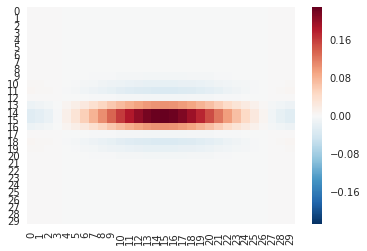

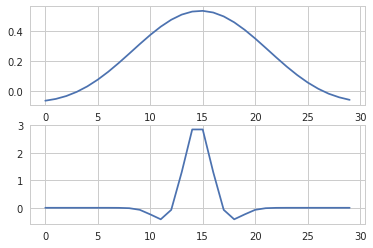

In [14]:
#Construct the filter
sres = nspec - 1 #resolution of the filter in pixels
tres = tlen      #time window of the filter in ms
maxfreq = 8000   #maximum frequency of the signal
latency = 75     #offset between stimulus and response in ms (range: 0 to time)
frequency = 4000 #centering frequency for the filter
A = 0.25         #amplitude of the wavelet peak -- probably don't need to change this
sigma = 0.01     #width of the filter in the time axis -- bigger sigma = narrower time band
gamma = 0.0015   #width of the filter in the frequency axis -- bigger gamma = narrower frequency band
alpha = 1        #depth of inhibitory sidebands on time axis -- bigger alpha = deeper sidebands
beta = 1         #depth of inhibitory sidebands on frequency axis -- bigger beta = deeper sidebands

#ss.strf returns three arguments: h is the strf, t and f are correctly labeled axes for plotting
k, t, f = utils.strf(sres,150,maxfreq,latency,frequency,A,sigma,gamma,alpha,beta)

k = resample(k,tres,axis=1)

figure()
sns.heatmap(k,linewidths = 0)

figure()
B = np.sum(k,axis=1)
A = np.sum(k,axis=0)
subplot(211)
plot(A)
subplot(212)
plot(B)

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True)
costim = tot(tim)
 
# set MAT model parameters
matparam  = [10,2,0,8]

### Generating noisy data

In [15]:
# data settings
ntrials = 5
noise = 1
dataparam = np.hstack((spec[0],costim[0],matparam))
M = dstrf(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,noise=noise,normalize=norm,center=center)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    dsdur = int(dur/t_dsample)
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

NameError: name 'dstrf' is not defined

In [ ]:
plot(model_data[0][0])

## Getting initial guess for STRF

In [ ]:
from sklearn.linear_model import ElasticNetCV
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [normalize(p,False) for p in assim_psth]

en_reg = ElasticNetCV(normalize=True)
en_reg.fit(np.vstack(assim_stims),np.hstack(fit_psth))

STRF_GUESS = np.fliplr(en_reg.coef_.reshape(nspec,tlen))
SPEC,TIM = utils.factorize(STRF_GUESS,channels)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

In [ ]:
# plot true and estimated strf
subplot(211)
sns.heatmap(np.reshape(M.pstrf.filt,(nspec,tlen)))

subplot(212)
strf_model = cosstrf_design(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

## Define loss and prior functions

In [ ]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

cost = spike_distance
unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return np.sum(np.abs(start[:-4])) + mat_prior(start[-4:])

## Run initial MAT parameter fit

In [ ]:
from neurofit import startpos
# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[5,0,0,1],[0.1]*4)
#p0 = startpos.normal_independent(nwalkers,matparam,[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),8)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

In [ ]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

#param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("MAT R: {:.3f}".format(np.mean(mat_corr)))

## Fit dSTRF model using emcee

In [ ]:
# initalize the model
model = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),8)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

## Evaluate the model fit

In [ ]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,cbar=False)

subplot(212)
sns.heatmap(model.pstrf.filt,cbar = False)
tight_layout()

In [ ]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,test_spiky,t_dsample,psth_smooth,plt=True,figsize=(4,1))
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("MAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

In [ ]:
from corner import corner

matlabs = ['a','b','c','w']
corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,mooth1d=5,
       labels=matlabs,
       truths=matparam);